# Lab-6: Kernel SVM, Principal Component Analysis
_____
##### In this lab, you will experiment with different kernels in SVM and implement PCA step by step.

### Objectives:
1. Explore SVM kernel types
2. Understand basic steps of PCA

## Kernel SVM

1. What is called a kernel trick?

### Most popular kernel types

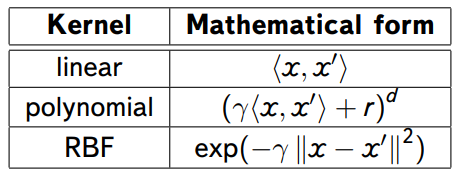



### Generating data

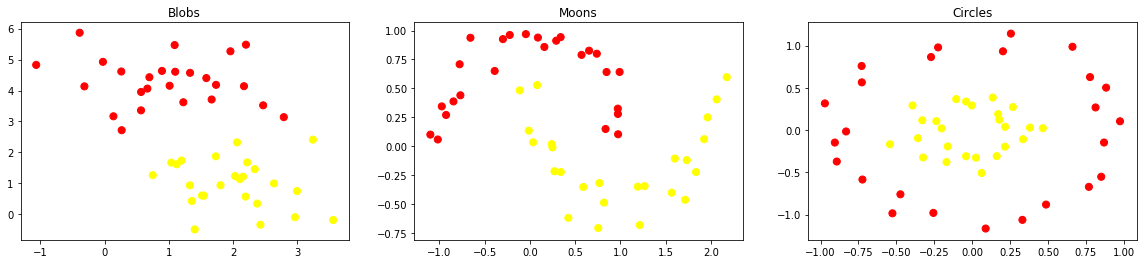

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs, make_moons, make_circles

# here we assign values for constants
n_samples = 50
C_const = 100

plt.figure(figsize=(20,4))

# generating linearly separable data
X_blob, Y_blob = make_blobs(n_samples=n_samples, centers=2, random_state=0, cluster_std=0.8)
plt.subplot("131")
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=Y_blob, s=50, cmap='autumn')
plt.title("Blobs")

# generating moon-shaped data
X_moon, Y_moon = make_moons(n_samples=n_samples, noise=0.1, random_state=0)
plt.subplot("132")
plt.title("Moons")
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=Y_moon, s=50, cmap='autumn')

# generating concentric data
X_circle, Y_circle = make_circles(n_samples=n_samples, factor=0.3, noise=0.1, random_state=0)
plt.subplot("133")
plt.title("Circles")
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=Y_circle, s=50, cmap='autumn')
plt.show()

In [7]:
# plotting function from the last lab, for your use
def plot_svc_decision_function(model, ax=None, plot_support=False):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=30, marker = "x", color="k")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

### Trying out different kernels

Task: For each dataset, try at east three kernels (linear, rbf, polynomial) with default patameters and plot the results. Analyze them.

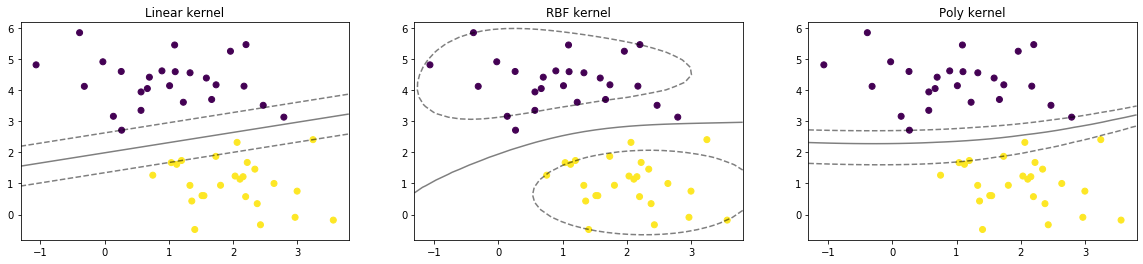

In [10]:
# test kernels for each dataset
def test_kernels(x, y):
    plt.figure(figsize=(20,4))
    linear_svc = svm.SVC(kernel='linear')
    linear_svc.fit(x,y)
    plt.subplot("131")
    plt.title("Linear kernel")
    plt.scatter(x[:,0],x[:,1],c=y)
    plot_svc_decision_function(linear_svc)

    rbf_svc = svm.SVC(kernel='rbf')
    rbf_svc.fit(x,y)
    plt.subplot("132")
    plt.title("RBF kernel")
    plt.scatter(x[:,0],x[:,1],c=y)
    plot_svc_decision_function(rbf_svc)

    poly_svc = svm.SVC(kernel='poly',degree=3)
    poly_svc.fit(x,y)
    plt.subplot("133")
    plt.title("Poly kernel")
    plt.scatter(x[:,0],x[:,1],c=y)
    plot_svc_decision_function(poly_svc)
# this is the approximate output you should get for the blobs dataset
test_kernels(X_blob, Y_blob)

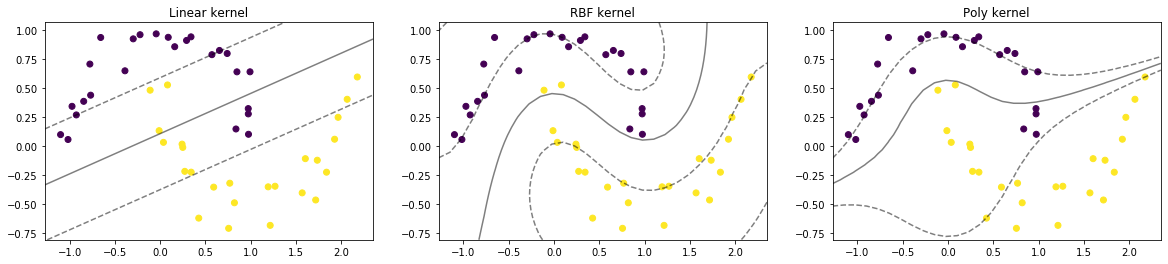

In [11]:
test_kernels(X_moon,Y_moon)

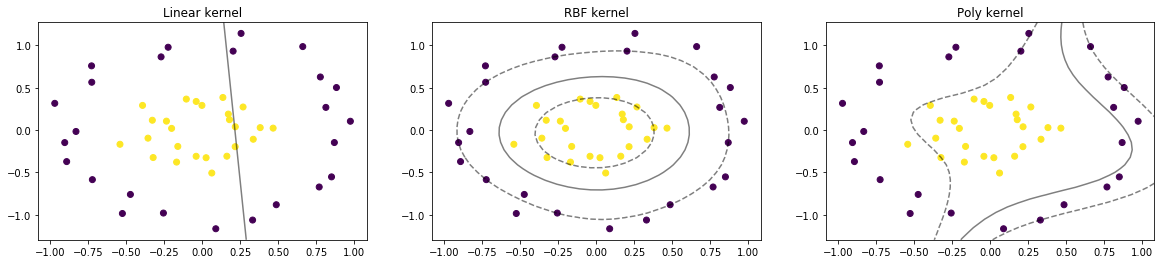

In [12]:
test_kernels(X_circle, Y_circle )

### Exploring parameters effect
Task: Try playing with C, gamma, degree parameters on the moons dataset - choose ones that you think perform best.

**gamma** - determines how close should the point be to hyperplane to have any impact on it. The lower the gamma, the more elements, even those that are far enough from the dividing line, take part in the process of choosing this very line. If, however, the gamma is high, then the algorithm will "rely" only on those elements that are closest to the line itself.

If you set the gamma level too high, then only the elements closest to the line will participate in the process of deciding on the position of the line. This will help ignore outliers in the data.



![alt text](http://cs604525.vk.me/v604525210/afd4/xuJnTRcY43g.jpg)

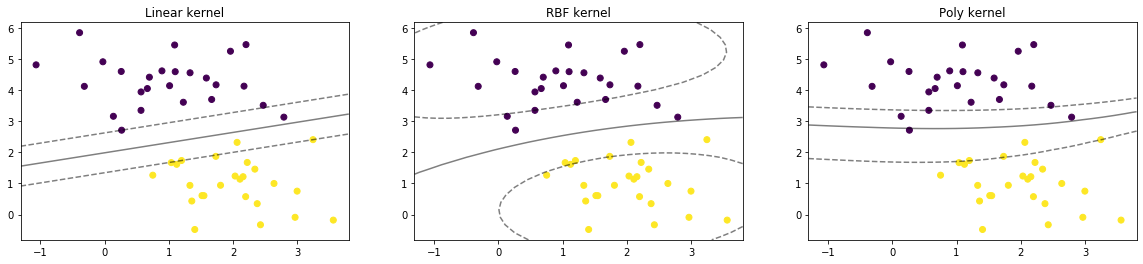

In [22]:
# Manually tune parameters for the moons dataset, plotting the result
def test_kernels2(x, y, degree=3, gamma="scale", c=1):
    plt.figure(figsize=(20,4))
    linear_svc = svm.SVC(kernel='linear',gamma=gamma,C=c)
    linear_svc.fit(x,y)
    plt.subplot("131")
    plt.title("Linear kernel")
    plt.scatter(x[:,0],x[:,1],c=y)
    plot_svc_decision_function(linear_svc)

    rbf_svc = svm.SVC(kernel='rbf', gamma=gamma,C=c)
    rbf_svc.fit(x,y)
    plt.subplot("132")
    plt.title("RBF kernel")
    plt.scatter(x[:,0],x[:,1],c=y)
    plot_svc_decision_function(rbf_svc)

    poly_svc = svm.SVC(kernel='poly',gamma=gamma, degree=degree, C=c)
    poly_svc.fit(x,y)
    plt.subplot("133")
    plt.title("Poly kernel")
    plt.scatter(x[:,0],x[:,1],c=y)
    plot_svc_decision_function(poly_svc)

test_kernels2(X_blob, Y_blob, gamma=0.1)

## PCA

1. How does PCA reduce data dimensionality? 
2. What is eigenvector? 

Task: Now you will implement basic steps of PCA: mean-centering, eigenvectors calculation using covariance matrix, projecting data to the first PC, and restoring it back.

### Generating data ###

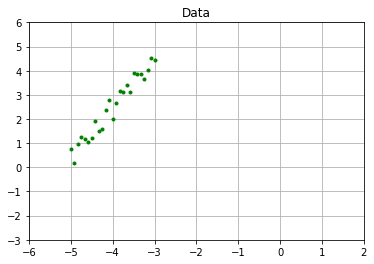

In [23]:
# N is a sample size
N = 25
# we can fix a random seed. It allows us to get the same data
np.random.seed(10)
# form our data
x = np.linspace(-5, -3, N)
y = 10 + 2*x + np.random.random(size=(N,))
data = np.stack([x,y], axis = 1)


plt.title("Data")
plt.plot(data[:,0], data[:,1], '.', color="green")
plt.axis([-6, 2, -3, 6])
plt.grid('True')

### Center data###

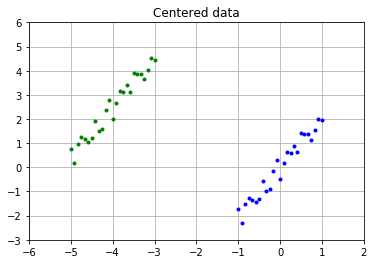

In [28]:
# center data by subtracting mean value from each feature

# pay attention to mean_vector <-- we need it later for restoring our data
mean_vector = np.mean(data,axis=0)
data_centered = data - mean_vector

plt.title("Centered data")
plt.plot(data[:,0], data[:,1], '.', color="green")
plt.plot(data_centered[:,0], data_centered[:,1], '.', color="blue")
plt.axis([-6, 2, -3, 6])
plt.grid('True')

### Covariance matrix ###

In [30]:
# calculate covariance matrix for our centered data
cov_mat = np.cov(data_centered)
print('Covariance matrix:\n', cov_mat)

# also, to make sure you understand how to calculate covariance, calculate and print cov(X,Y)
# check that it is the same as in the covariance matrix
cov_xy = (1/(N-1))* np.sum(data_centered[:,0]*data_centered[:,1])
print('cov(X,Y):', cov_xy)

Covariance matrix:
 [[ 2.65892586e-01  5.09178616e-01  2.55320757e-01  1.82948100e-01
   2.43826013e-01  3.13240908e-01  2.92603692e-01  5.71329503e-02
   2.42390454e-01  2.41456190e-01 -6.61289042e-03 -1.34727576e-01
   1.81072365e-01 -3.46273836e-02 -1.74553932e-01 -1.31980564e-01
  -2.02192350e-01 -7.58354676e-02 -3.34434005e-01 -2.90729065e-01
  -2.58388147e-01 -1.42789293e-01 -2.57463132e-01 -3.97522459e-01
  -3.43206368e-01]
 [ 5.09178616e-01  9.75066158e-01  4.88933790e-01  3.50341699e-01
   4.66921599e-01  5.99849639e-01  5.60329811e-01  1.09408378e-01
   4.64172535e-01  4.62383438e-01 -1.26635437e-02 -2.58000427e-01
   3.46749707e-01 -6.63106990e-02 -3.34267046e-01 -2.52739956e-01
  -3.87194025e-01 -1.45223298e-01 -6.40433966e-01 -5.56739941e-01
  -4.94807774e-01 -2.73438442e-01 -4.93036391e-01 -7.61247006e-01
  -6.57232855e-01]
 [ 2.55320757e-01  4.88933790e-01  2.45169262e-01  1.75674125e-01
   2.34131546e-01  3.00786521e-01  2.80969835e-01  5.48613572e-02
   2.32753065e-01 

### Eigenvectors and eigenvalues

In [33]:
# compute eigenvectors and eigenvalues, print them
eig_values, eig_vectors = np.linalg.eig(cov_mat)
# print('eig_values:', eig_values)
# print('eig_vectors:\n', eig_vectors)

# are they already in the needed order?
# if not, order eigenvectors and eigenvalues by eigenvalues, descending
sorted_idx = np.argsort(eig_values)[::-1]
eig_values= eig_values[sorted_idx]

eig_vectors = eig_vectors[:, sorted_idx]

# print('\nsorteed eig_values:', eig_values)
# print('sorted eig_vectors:\n', eig_vectors)

# estimate variance retained by each principal component
retained_var = eig_values / sum(eig_values)
print('\nretained variance:',   retained_var)


retained variance: [ 1.00000000e+00+0.00000000e+00j  1.84633704e-17+0.00000000e+00j
  1.40783617e-17+0.00000000e+00j  1.17108635e-17+0.00000000e+00j
  9.17035333e-18+1.25087270e-18j  9.17035333e-18-1.25087270e-18j
  5.89519163e-18+0.00000000e+00j  2.65973594e-18+4.01684015e-19j
  2.65973594e-18-4.01684015e-19j  1.19632183e-18+0.00000000e+00j
  1.76314169e-19+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -1.69310676e-20+0.00000000e+00j -1.78699340e-19+0.00000000e+00j
 -3.75142583e-19+0.00000000e+00j -1.85661248e-18+2.69324417e-18j
 -1.85661248e-18-2.69324417e-18j -3.01608711e-18+1.21009303e-19j
 -3.01608711e-18-1.21009303e-19j -5.25491990e-18+0.00000000e+00j
 -1.06408780e-17+1.46113062e-17j -1.06408780e-17-1.46113062e-17j
 -1.13892650e-17+1.80944023e-18j -1.13892650e-17-1.80944023e-18j
 -2.08296485e-17+0.00000000e+00j]


### Project data ###

In [35]:
# project data to the first principal component
first_pc = eig_vectors[:,0:]
projected_data = np.matmul(data_centered,first_pc)

plt.title("Projected data")
plt.plot(data[:,0], data[:,1], '.', color="green")
plt.plot(data_centered[:,0], data_centered[:,1], '.', color="blue")
plt.plot(projected_data, np.zeros(len(projected_data)), '.', color="red")
plt.axis([-6, 3, -3, 6])
plt.grid('True')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 25 is different from 2)

### Restore data back ###

In [ ]:
# project data back to initial space
# remember to add a mean_vector to the restored data
restored_data = None

plt.title("Restored data")
plt.plot(data[:,0], data[:,1], '.', color="green")
plt.plot(data_centered[:,0], data_centered[:,1], '.', color="blue")
plt.plot(restored_data[:,0], restored_data[:,1], '.', color="red")
plt.axis([-6, 2, -3, 6])
plt.grid('True')
plt.show()

### SKLEARN implementation ###

[-4.          2.50055666]
[[-0.42519979 -0.90509952]]
[2.01099716]
[0.99242201]


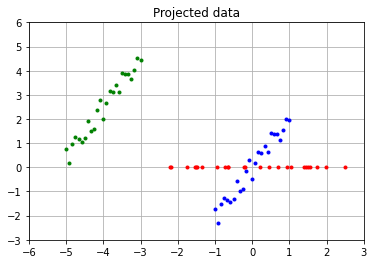

In [15]:
# this is to check your solution
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
x_PCA = pca.fit_transform(data)

plt.title("Projected data")
plt.plot(data[:,0], data[:,1], '.', color="green")
plt.plot(data_centered[:,0], data_centered[:,1], '.', color="blue")
plt.plot(x_PCA, np.zeros(len(projected_data)), '.', color="red")
plt.axis([-6, 3, -3, 6])
plt.grid('True')

print(pca.mean_)
print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)